In [35]:
import pandas as pd, os, textwrap, math, statistics, numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv("merged_astronauts3132321321.csv")
df.shape, df.columns

((357, 24),
 Index(['Name', 'Year', 'Group', 'Status', 'Birth Date', 'Birth Place',
        'Gender_x', 'Alma Mater', 'Undergraduate Major', 'Graduate Major',
        'Military Rank', 'Military Branch', 'Space Flights',
        'Space Flight (hr)', 'Space Walks', 'Space Walks (hr)', 'Missions',
        'Death Date', 'Death Mission', 'Country', 'Gender_y', 'Flights',
        'Total Flights', 'Total Flight Time (ddd:hh:mm)'],
       dtype='object'))

In [5]:
df_analysis = df[df["Space Flight (hr)"] > 0].copy()
df_analysis.shape

(330, 24)

In [6]:
cols_to_drop = [c for c in ["Gender_y", "Flights", "Total Flights"] if c in df_analysis.columns]
df_analysis2 = df_analysis.drop(columns=cols_to_drop).rename(columns={"Gender_x": "Gender"})
df_analysis2.shape, df_analysis2.columns

((330, 21),
 Index(['Name', 'Year', 'Group', 'Status', 'Birth Date', 'Birth Place',
        'Gender', 'Alma Mater', 'Undergraduate Major', 'Graduate Major',
        'Military Rank', 'Military Branch', 'Space Flights',
        'Space Flight (hr)', 'Space Walks', 'Space Walks (hr)', 'Missions',
        'Death Date', 'Death Mission', 'Country',
        'Total Flight Time (ddd:hh:mm)'],
       dtype='object'))

“Given things like major, military branch, 
and a few basic demographics, can we predict how much time an astronaut spends in space or how many flights they get?”

In [7]:
df_analysis2[["Undergraduate Major","Graduate Major","Military Branch","Military Rank","Space Flight (hr)","Space Flights","Space Walks (hr)","Space Walks"]].notna().sum()

Undergraduate Major    311
Graduate Major         277
Military Branch        199
Military Rank          195
Space Flight (hr)      330
Space Flights          330
Space Walks (hr)       330
Space Walks            330
dtype: int64

In [8]:
model_df = df_analysis2[["Undergraduate Major","Graduate Major","Military Branch","Space Flight (hr)","Space Flights","Gender","Year"]].dropna()
model_df.shape

(144, 7)

In [9]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

X = pd.get_dummies(model_df[["Undergraduate Major","Graduate Major","Military Branch","Gender","Year"]], drop_first=True)
y_hr = model_df["Space Flight (hr)"]
y_flights = model_df["Space Flights"]

X.shape

(144, 130)

In [10]:
majors = sorted(df_analysis2["Undergraduate Major"].dropna().unique())
len(majors), majors[:30]

(82,
 ['Accounting',
  'Aeronautical & Astronautical Engineering',
  'Aeronautical Engineering',
  'Aeronautics & Astronautics',
  'Aeronautics & Astronautics; Earth, Atmospheric & Planetary Sciences',
  'Aerospace Engineering',
  'Aerospace Engineering & Mechanics',
  'Animal Nutrition',
  'Animal Science',
  'Applied Biology; Mechanical Engineering',
  'Applied Mathematics',
  'Applied Science & Engineering',
  'Astronautical Engineering',
  'Astronautics',
  'Astronomy',
  'Biological Science',
  'Biology',
  'Biology & Psychology',
  'Bioscience',
  'Business Economics',
  'Business Finance',
  'Business Management; Aeronautical Engineering',
  'Ceramic Engineering',
  'Chemical Engineering',
  'Chemistry',
  'Chemistry & Biology',
  'Chemistry; Physiological Optics',
  'Civil Engineering',
  'Computer & Systems Engineering',
  'Computer Science'])

In [12]:
sorted(df_analysis2["Military Branch"].dropna().unique())

['US Air Force',
 'US Air Force (Retired)',
 'US Air Force Reserves',
 'US Air Force Reserves (Retired)',
 'US Army',
 'US Army (Retired)',
 'US Coast Guard (Retired)',
 'US Marine Corps',
 'US Marine Corps (Retired)',
 'US Marine Corps Reserves',
 'US Naval Reserves',
 'US Naval Reserves (Retired)',
 'US Navy',
 'US Navy (Retired)']

In [13]:
import numpy as np

def simplify_branch(b):
    if pd.isna(b):
        return "Civilian"
    s = str(b)
    if "Air Force" in s:
        return "Air Force"
    if "Army" in s:
        return "Army"
    if "Navy" in s:
        return "Navy"
    if "Marine" in s:
        return "Marines"
    if "Coast Guard" in s:
        return "Coast Guard"
    return "Other Military"

def is_stem_major(m):
    if pd.isna(m):
        return np.nan
    s = str(m)
    stem_keywords = ["Engineering","Physics","Math","Science","Astronomy","Chemistry","Biology",
                     "Geology","Geophysics","Mechanics","Astronautics","Aeronautics","Aerospace",
                     "Computer","Electrical","Mechanical","Applied","Operations Research"]
    return int(any(k in s for k in stem_keywords))

df_feat = df_analysis2.copy()
df_feat["BranchSimple"] = df_feat["Military Branch"].apply(simplify_branch)
df_feat["UndergradSTEM"] = df_feat["Undergraduate Major"].apply(is_stem_major)

df_feat["BranchSimple"].value_counts(), df_feat["UndergradSTEM"].value_counts(dropna=False)

(BranchSimple
 Civilian          131
 Air Force          83
 Navy               75
 Marines            20
 Army               16
 Other Military      3
 Coast Guard         2
 Name: count, dtype: int64,
 UndergradSTEM
 1.0    296
 NaN     19
 0.0     15
 Name: count, dtype: int64)

So every astronaut is now either:

Air Force, Army, Navy, Marines, Coast Guard, Other Military, or Civilian.

built a binary STEM indicator from the undergrad major 0 for no 1 for yes

In [14]:
model2 = df_feat[["Space Flight (hr)", "Space Flights","UndergradSTEM","BranchSimple","Gender","Year"]].dropna()
model2.shape

(288, 6)

In [15]:
X2 = pd.get_dummies(model2[["UndergradSTEM","BranchSimple","Gender","Year"]], drop_first=True)
y_hr2 = model2["Space Flight (hr)"]
y_fl2 = model2["Space Flights"]
X2.shape

(288, 9)

Predictors (X2):

UndergradSTEM (0/1)

BranchSimple (dummy-coded)

Gender (dummy-coded)

Year (as a numeric year)

Targets:

y_hr2 = Space Flight (hr)

y_fl2 = Space Flights

In [16]:
linreg = LinearRegression()
linreg.fit(X2, y_hr2)
linreg.score(X2, y_hr2), linreg.coef_, X2.columns

(0.15398097978497816,
 array([-231.37173309,   50.72384316, 1861.13805184,  286.19244078,
         858.76284288, -346.08491768,  137.34328596,  730.64260452,
          40.84426545]),
 Index(['UndergradSTEM', 'Year', 'BranchSimple_Army', 'BranchSimple_Civilian',
        'BranchSimple_Coast Guard', 'BranchSimple_Marines', 'BranchSimple_Navy',
        'BranchSimple_Other Military', 'Gender_Male'],
       dtype='object'))

fit a plain linear regression model for space-flight hours:

Training R² ≈ 0.154 (15.4% of variance explained on the same data)

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(linreg, X2, y_hr2, cv=kf, scoring='r2')
cv_scores.mean(), cv_scores

(np.float64(0.06422817391984759),
 array([ 0.18368165, -0.03599624,  0.06052168,  0.02443042,  0.08850337]))

In [18]:
cv_scores_fl = cross_val_score(linreg, X2, y_fl2, cv=kf, scoring='r2')
cv_scores_fl.mean(), cv_scores_fl

(np.float64(-0.07315495875441265),
 array([-0.11718717, -0.14562621, -0.01129884, -0.04130739, -0.05035518]))

In [52]:
X_hd = pd.get_dummies(model_df[["Undergraduate Major","Graduate Major","Military Branch","Gender","Year"]], drop_first=True)
scaler = StandardScaler()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X_hd))
import numpy as np
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]
def corr(a,b):
    return np.corrcoef(a,b)[0,1]
corr(pc1, y_hr), corr(pc2, y_hr), corr(pc1, y_fl2[:len(pc1)]), corr(pc2, y_fl2[:len(pc2)])

df_feat = df_feat.copy()

# Treat Naval Reserve as Navy before simplifying
def recode_branch_raw(b):
    if pd.isna(b):
        return b
    s = str(b)
    if "Naval Reserve" in s:
        return "US Navy"
    return s

df_feat["Military Branch"] = df_feat["Military Branch"].apply(recode_branch_raw)

# Then run your existing simplify_branch() on this cleaned column
df_feat["BranchSimple"] = df_feat["Military Branch"].apply(simplify_branch)
df_feat["BranchSimple"].value_counts()

BranchSimple
Civilian       131
Air Force       83
Navy            78
Marines         20
Army            16
Coast Guard      2
Name: count, dtype: int64

Interpretation:

There is some linear relationship between “overall background pattern” (PC1) and space-flight hours, but it’s not super strong (r ≈ 0.30).

There is almost no relationship between those background patterns and number of flights.

“If you compress all the nuanced background info into a couple of hidden axes, one of those axes has a modest association with space-flight hours, but almost none with how many missions you get.”

In [53]:
df_feat.groupby("BranchSimple")["Space Flight (hr)"].mean().round(1)

BranchSimple
Air Force      1097.4
Army           2821.2
Civilian       1406.2
Coast Guard    2411.5
Marines         702.0
Navy           1367.8
Name: Space Flight (hr), dtype: float64

In [54]:
df_feat.groupby("UndergradSTEM")["Space Flight (hr)"].mean().round(1)

UndergradSTEM
0.0    1455.5
1.0    1406.8
Name: Space Flight (hr), dtype: float64

In [55]:
df_feat.groupby("BranchSimple")["Space Flights"].mean().round(2)

BranchSimple
Air Force      2.60
Army           2.56
Civilian       2.46
Coast Guard    2.50
Marines        2.60
Navy           2.62
Name: Space Flights, dtype: float64

These are all basically ~2.5–2.6 flights on average, except “Other Military” but that’s based on only 3 people.

So descriptively, branch barely affects the number of missions.

--------------------------------------

Linear regression model

Tried to predict space-flight hours from UndergradSTEM, BranchSimple, Gender, and Year.

Found:

Some branch differences and a positive trend with year.

Overall predictive power is weak (CV R² ≈ 0.06).

Tried to predict number of flights from the same variables.

Predictive power basically zero / negative (CV R² ≈ –0.07).

PCA model

Collapsed detailed majors + branch info into 2 PCs.

PC1 moderately correlated with hours (r ≈ 0.30), almost no correlation with flights.

Descriptive stats

Some branches have higher average hours (e.g., Army, Coast Guard, “Other Military”), but sample sizes are small and variation is large.

STEM vs non-STEM majors have almost identical average hours.

Branch doesn’t meaningfully change average number of flights (~2.5 for everyone).

Answer to your research question, based on your own models:

For NASA astronauts, background information like major or military branch shows some association with total time spent in space (certain branches tend to have higher average hours), but these variables alone are weak predictors and don’t reliably predict either space-flight hours or number of missions. Other factors not in this dataset (mission role, program era, health, politics, etc.) probably play a much bigger role.

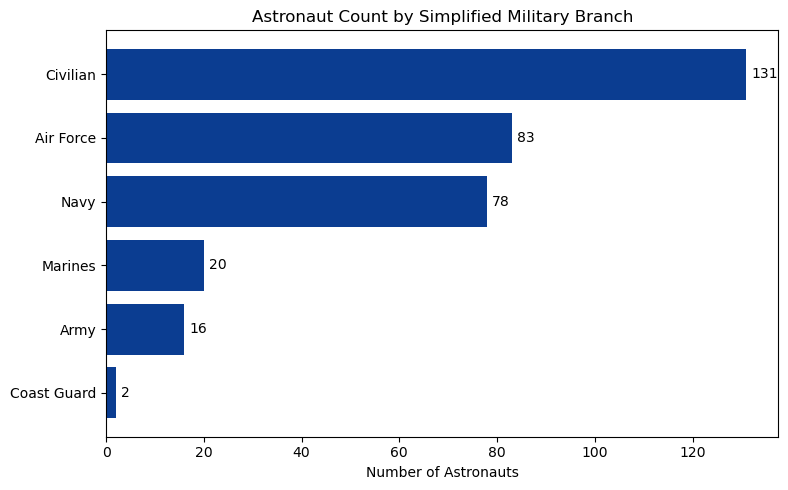

In [56]:
import matplotlib.pyplot as plt
branch_counts = (
    df_feat["BranchSimple"]
    .value_counts()
    .sort_values()
)

fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(branch_counts.index, branch_counts.values, color="#0B3D91")

# Add labels with counts at the end of each bar
for i, (name, val) in enumerate(branch_counts.items()):
    ax.text(val + 1, i, str(val), va="center", fontsize=10)

ax.set_xlabel("Number of Astronauts")
ax.set_title("Astronaut Count by Simplified Military Branch")

plt.tight_layout()
plt.savefig("fig1_branch_counts.png", dpi=300, bbox_inches="tight")
plt.show()

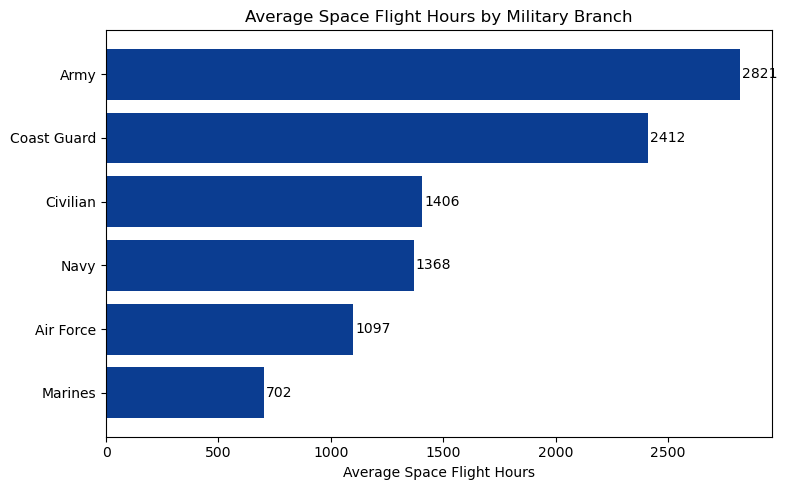

In [57]:
branch_hours = (
    df_feat.groupby("BranchSimple")["Space Flight (hr)"]
    .mean()
    .sort_values()
)

fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(branch_hours.index, branch_hours.values, color="#0B3D91")

for i, (name, val) in enumerate(branch_hours.items()):
    ax.text(val + 10, i, f"{val:.0f}", va="center", fontsize=10)

ax.set_xlabel("Average Space Flight Hours")
ax.set_title("Average Space Flight Hours by Military Branch")

plt.tight_layout()
plt.savefig("fig2_branch_hours.png", dpi=300, bbox_inches="tight")
plt.show()

^^^^^^^These two together play the same role as the “Income / Employment” bars in the example PDF.
----------------------------------

-----------------------------------------------

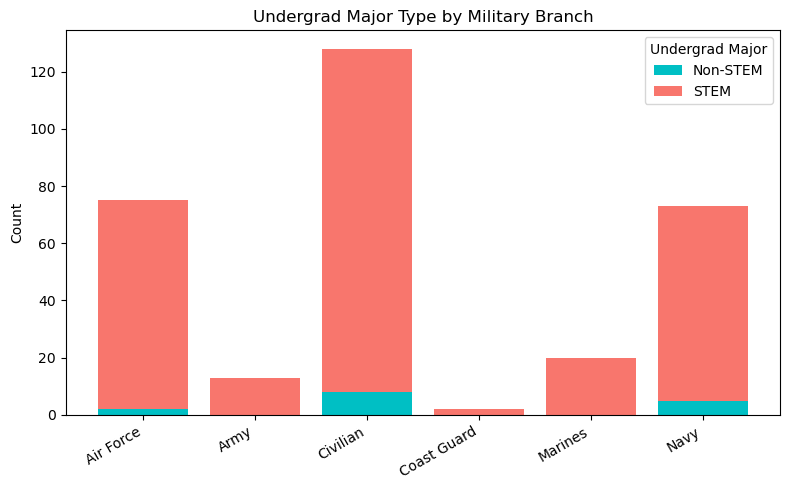

In [58]:
df_feat = df_feat.copy()
df_feat["UndergradLabel"] = df_feat["UndergradSTEM"].map(
    {1.0: "STEM", 0.0: "Non-STEM"}
)

ct = pd.crosstab(df_feat["BranchSimple"], df_feat["UndergradLabel"])
ct = ct[["Non-STEM", "STEM"]]  # fixed order

fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(ct.index))

ax.bar(x, ct["Non-STEM"], label="Non-STEM", color="#00BFC4")
ax.bar(x, ct["STEM"], bottom=ct["Non-STEM"], label="STEM", color="#F8766D")

ax.set_xticks(x)
ax.set_xticklabels(ct.index, rotation=30, ha="right")
ax.set_ylabel("Count")
ax.set_title("Undergrad Major Type by Military Branch")
ax.legend(title="Undergrad Major")

plt.tight_layout()
plt.savefig("fig3_branch_stem_stacked.png", dpi=300, bbox_inches="tight")
plt.show()

In [59]:
model2 = df_feat[[
    "Space Flight (hr)", "Space Flights",
    "UndergradSTEM", "BranchSimple", "Gender", "Year"
]].dropna()

X2 = pd.get_dummies(
    model2[["UndergradSTEM", "BranchSimple", "Gender", "Year"]],
    drop_first=True
)

y_hr2 = model2["Space Flight (hr)"]
y_fl2 = model2["Space Flights"]

linreg_hr = LinearRegression().fit(X2, y_hr2)
linreg_fl = LinearRegression().fit(X2, y_fl2)

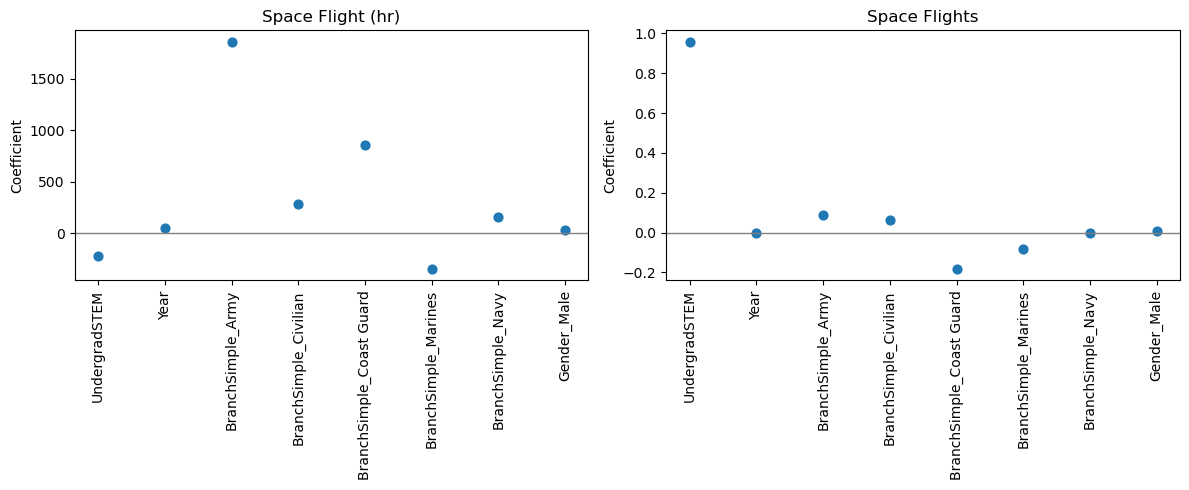

In [60]:
coef_df = pd.DataFrame({
    "Feature": list(X2.columns) * 2,
    "Coefficient": list(linreg_hr.coef_) + list(linreg_fl.coef_),
    "Outcome": (["Space Flight (hr)"] * len(X2.columns) +
                ["Space Flights"] * len(X2.columns))
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for ax, outcome in zip(axes, coef_df["Outcome"].unique()):
    sub = coef_df[coef_df["Outcome"] == outcome].reset_index(drop=True)
    ax.axhline(0, color="grey", linewidth=1)
    ax.scatter(np.arange(len(sub)), sub["Coefficient"], s=40)
    ax.set_xticks(np.arange(len(sub)))
    ax.set_xticklabels(sub["Feature"], rotation=90)
    ax.set_ylabel("Coefficient")
    ax.set_title(outcome)

plt.tight_layout()
plt.savefig("fig4_coefficients_side_by_side.png", dpi=300, bbox_inches="tight")
plt.show()

In [61]:
n_runs = 100
rows = []

feature_names = list(X2.columns)

for run in range(n_runs):
    # Different random_state each time to shuffle differently
    X_train, X_test, y_hr_train, y_hr_test, y_fl_train, y_fl_test = train_test_split(
        X2, y_hr2, y_fl2,
        test_size=0.30,
        random_state=run
    )
    
    # Fit both models on the TRAIN set
    model_hr = LinearRegression()
    model_hr.fit(X_train, y_hr_train)
    
    model_fl = LinearRegression()
    model_fl.fit(X_train, y_fl_train)
    
    # Store coefficients for each feature / outcome
    for j in range(len(feature_names)):
        feat = feature_names[j]
        
        # Space Flight (hr) coefficient
        row_hr = {
            "Run": run,
            "Feature": feat,
            "Coefficient": model_hr.coef_[j],
            "Outcome": "Space Flight (hr)"
        }
        rows.append(row_hr)
        
        # Space Flights coefficient
        row_fl = {
            "Run": run,
            "Feature": feat,
            "Coefficient": model_fl.coef_[j],
            "Outcome": "Space Flights"
        }
        rows.append(row_fl)

coef_runs = pd.DataFrame(rows)
coef_runs.head()


,Run,Feature,Coefficient,Outcome
0,0,UndergradSTEM,-55.107516,Space Flight (hr)
1,0,UndergradSTEM,1.075903,Space Flights
2,0,Year,54.259501,Space Flight (hr)
3,0,Year,0.005199,Space Flights
4,0,BranchSimple_Army,1076.732626,Space Flight (hr)


C:\Users\cazuh\AppData\Local\Temp\ipykernel_3448\1792168128.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(
C:\Users\cazuh\AppData\Local\Temp\ipykernel_3448\1792168128.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


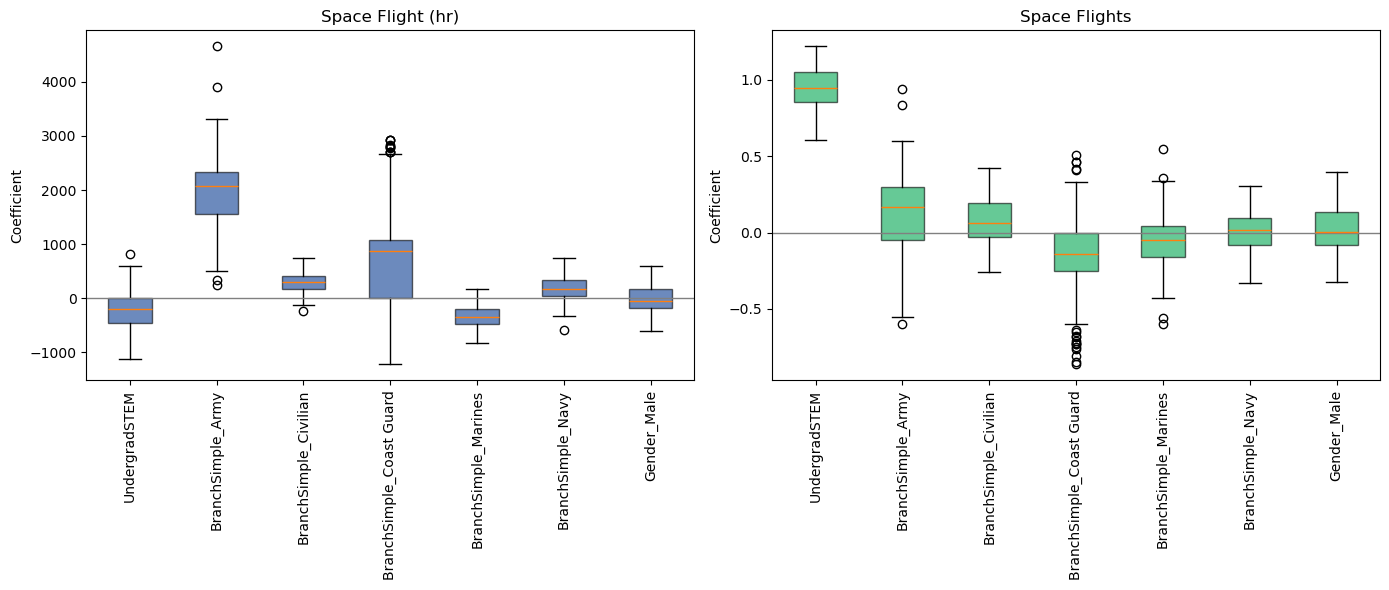

In [62]:
nasa_blue = "#0B3D91"
nasa_green = "#00A651"

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

outcome_list = ["Space Flight (hr)", "Space Flights"]
color_list = [nasa_blue, nasa_green]

# NEW: choose feature order without "Year"
feature_order = []
for name in X2.columns:
    if name != "Year":
        feature_order.append(name)

for idx in range(len(outcome_list)):
    outcome = outcome_list[idx]
    color = color_list[idx]
    ax = axes[idx]

    # subset to this outcome and NOT Year
    sub = coef_runs[
        (coef_runs["Outcome"] == outcome) &
        (coef_runs["Feature"] != "Year")
    ]

    data = []
    for feat in feature_order:
        coef_values = sub[sub["Feature"] == feat]["Coefficient"].values
        data.append(coef_values)

    box = ax.boxplot(
        data,
        vert=True,
        patch_artist=True,
        labels=feature_order
    )

    for b in box["boxes"]:
        b.set_facecolor(color)
        b.set_alpha(0.6)

    ax.axhline(0, color="grey", linewidth=1)
    ax.set_title(outcome)
    ax.set_ylabel("Coefficient")
    ax.set_xticklabels(feature_order, rotation=90)

plt.tight_layout()
plt.savefig("fig4_coefficients_boxplots_no_year.png", dpi=300, bbox_inches="tight")
plt.show()


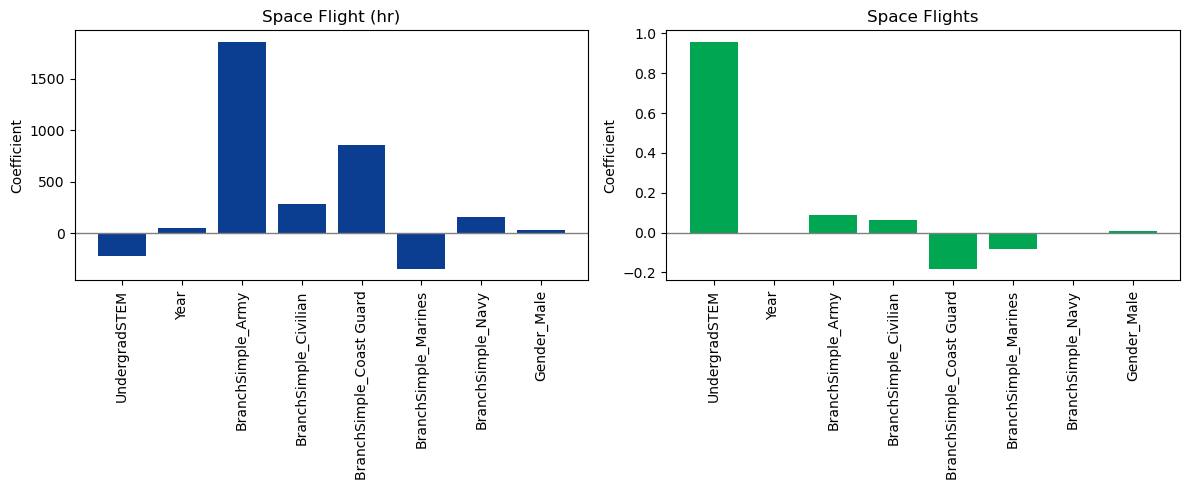

In [63]:
import matplotlib.pyplot as plt

nasa_blue = "#0B3D91"
nasa_green = "#00A651"  # nice contrasting color

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for ax, outcome, color in zip(
    axes,
    ["Space Flight (hr)", "Space Flights"],
    [nasa_blue, nasa_green]
):
    sub = coef_df[coef_df["Outcome"] == outcome].reset_index(drop=True)
    
    x_pos = range(len(sub))
    
    ax.axhline(0, color="grey", linewidth=1)
    ax.bar(x_pos, sub["Coefficient"], color=color)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sub["Feature"], rotation=90)
    ax.set_ylabel("Coefficient")
    ax.set_title(outcome)

plt.tight_layout()
plt.savefig("fig4_coefficients_bar_train.png", dpi=300, bbox_inches="tight")
plt.show()

In [64]:
feature_mean = X2.mean()

def predict_with(**changes):
    """
    Return predicted hours when some features are set to given values
    and the rest are held at their mean.
    """
    x = feature_mean.copy()
    for k, v in changes.items():
        x[k] = v
    return linreg_hr.predict([x.values])[0]

C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


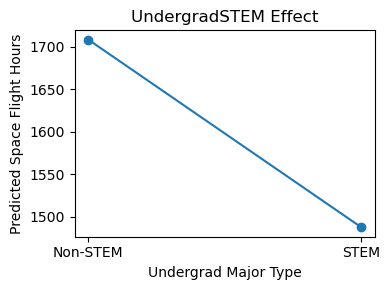

In [65]:
vals = [0, 1]
preds = [predict_with(UndergradSTEM=v) for v in vals]

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(vals, preds, marker="o")
ax.set_xticks(vals)
ax.set_xticklabels(["Non-STEM", "STEM"])
ax.set_ylabel("Predicted Space Flight Hours")
ax.set_xlabel("Undergrad Major Type")
ax.set_title("UndergradSTEM Effect")

plt.tight_layout()
plt.savefig("fig5_effect_undergradstem.png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


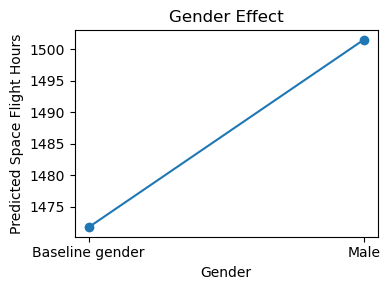

In [66]:
gender_col = [c for c in X2.columns if c.startswith("Gender_")][0]

vals = [0, 1]
preds = [predict_with(**{gender_col: v}) for v in vals]

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(vals, preds, marker="o")
ax.set_xticks(vals)
ax.set_xticklabels(["Baseline gender", gender_col.split("_")[1]])
ax.set_ylabel("Predicted Space Flight Hours")
ax.set_xlabel("Gender")
ax.set_title("Gender Effect")

plt.tight_layout()
plt.savefig("fig6_effect_gender.png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\

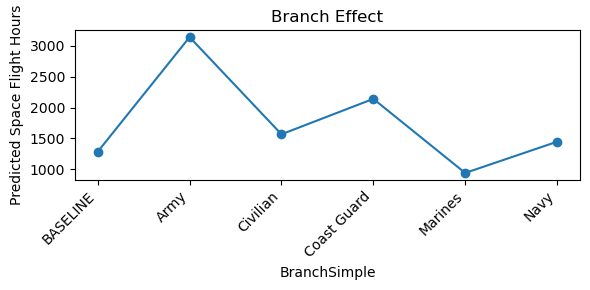

In [67]:
branch_dummy_cols = [c for c in X2.columns if c.startswith("BranchSimple_")]
branches = ["BASELINE"] + [c.split("BranchSimple_")[1] for c in branch_dummy_cols]

preds = []
for b in branches:
    # start from all-means
    x = feature_mean.copy()
    # zero out all branch dummies
    for col in branch_dummy_cols:
        x[col] = 0
    # set the relevant dummy to 1 (if not baseline)
    if b != "BASELINE":
        col_name = "BranchSimple_" + b
        x[col_name] = 1
    preds.append(linreg_hr.predict([x.values])[0])

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(len(branches)), preds, marker="o")
ax.set_xticks(range(len(branches)))
ax.set_xticklabels(branches, rotation=45, ha="right")
ax.set_ylabel("Predicted Space Flight Hours")
ax.set_xlabel("BranchSimple")
ax.set_title("Branch Effect")

plt.tight_layout()
plt.savefig("fig7_effect_branch.png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cazuh\anaconda3\

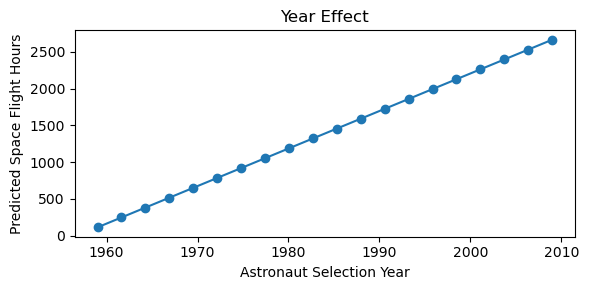

In [68]:
year_min = int(model2["Year"].min())
year_max = int(model2["Year"].max())

years = np.linspace(year_min, year_max, 20)
preds = [predict_with(Year=y) for y in years]

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(years, preds, marker="o")
ax.set_xlabel("Astronaut Selection Year")
ax.set_ylabel("Predicted Space Flight Hours")
ax.set_title("Year Effect")

plt.tight_layout()
plt.savefig("fig8_effect_year.png", dpi=300, bbox_inches="tight")
plt.show()

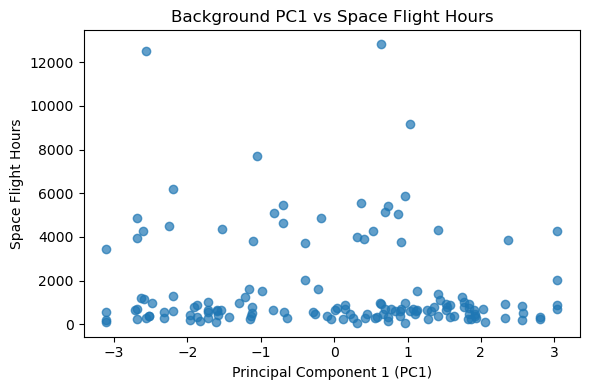

In [69]:
cols_for_pca = ["Undergraduate Major", "Graduate Major", "Military Branch"]
pca_df = df_feat.dropna(subset=cols_for_pca + ["Space Flight (hr)"]).copy()

X_hd = pd.get_dummies(pca_df[cols_for_pca])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hd)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pc1 = X_pca[:, 0]

fig, ax = plt.subplots(figsize=(6, 4))
sc = ax.scatter(pc1, pca_df["Space Flight (hr)"], alpha=0.7)
ax.set_xlabel("Principal Component 1 (PC1)")
ax.set_ylabel("Space Flight Hours")
ax.set_title("Background PC1 vs Space Flight Hours")

plt.tight_layout()
plt.savefig("fig9_pca_pc1_vs_hours.png", dpi=300, bbox_inches="tight")
plt.show()

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Start from df_feat (must already exist)
# We need rows with non-missing undergrad major + outcomes
df_major = df_feat.dropna(
    subset=["Undergraduate Major", "Space Flight (hr)", "Space Flights"]
).copy()

# Count majors and keep only those with at least 5 astronauts
major_counts = df_major["Undergraduate Major"].value_counts()
keep_majors = major_counts[major_counts >= 5].index.tolist()

print("Majors kept (n >= 5):")
for m in keep_majors:
    print(m)

# Filter to only those majors
df_major = df_major[df_major["Undergraduate Major"].isin(keep_majors)].copy()
print("Rows after major filter:", df_major.shape[0])


Majors kept (n >= 5):
Aerospace Engineering
Physics
Aeronautical Engineering
Mechanical Engineering
Electrical Engineering
Engineering Science
Mathematics
Engineering
Chemistry
Chemical Engineering
Astronautical Engineering
Naval Sciences
Aeronautical & Astronautical Engineering
Civil Engineering
Mathematics & Physics
Geology
Rows after major filter: 222


In [71]:
# One-hot encode Undergraduate Major
X_maj = pd.get_dummies(df_major["Undergraduate Major"], drop_first=True)

y_hr_maj = df_major["Space Flight (hr)"]
y_fl_maj = df_major["Space Flights"]

feature_names_maj = list(X_maj.columns)
print("Number of major dummy features:", len(feature_names_maj))


Number of major dummy features: 15


In [72]:
n_runs = 100
rows_maj = []

for run in range(n_runs):
    # Train/test split (same random_state trick as before)
    X_train, X_test, y_hr_train, y_hr_test, y_fl_train, y_fl_test = train_test_split(
        X_maj, y_hr_maj, y_fl_maj,
        test_size=0.30,
        random_state=run
    )
    
    # Fit models for both outcomes on TRAIN set
    model_hr = LinearRegression()
    model_hr.fit(X_train, y_hr_train)
    
    model_fl = LinearRegression()
    model_fl.fit(X_train, y_fl_train)
    
    # Store coefficients for each feature / outcome
    for j in range(len(feature_names_maj)):
        feat = feature_names_maj[j]
        
        # Space Flight (hr)
        row_hr = {
            "Run": run,
            "Feature": feat,
            "Coefficient": model_hr.coef_[j],
            "Outcome": "Space Flight (hr)"
        }
        rows_maj.append(row_hr)
        
        # Space Flights
        row_fl = {
            "Run": run,
            "Feature": feat,
            "Coefficient": model_fl.coef_[j],
            "Outcome": "Space Flights"
        }
        rows_maj.append(row_fl)

coef_runs_maj = pd.DataFrame(rows_maj)
coef_runs_maj.head()


,Run,Feature,Coefficient,Outcome
0,0,Aeronautical Engineering,-58.000000,Space Flight (hr)
1,0,Aeronautical Engineering,-0.454545,Space Flights
2,0,Aerospace Engineering,475.090909,Space Flight (hr)
3,0,Aerospace Engineering,-0.409091,Space Flights
4,0,Astronautical Engineering,8.000000,Space Flight (hr)


In [73]:
n_runs = 100
rows_maj = []

for run in range(n_runs):
    # Train/test split (same random_state trick as before)
    X_train, X_test, y_hr_train, y_hr_test, y_fl_train, y_fl_test = train_test_split(
        X_maj, y_hr_maj, y_fl_maj,
        test_size=0.30,
        random_state=run
    )
    
    # Fit models for both outcomes on TRAIN set
    model_hr = LinearRegression()
    model_hr.fit(X_train, y_hr_train)
    
    model_fl = LinearRegression()
    model_fl.fit(X_train, y_fl_train)
    
    # Store coefficients for each feature / outcome
    for j in range(len(feature_names_maj)):
        feat = feature_names_maj[j]
        
        # Space Flight (hr)
        row_hr = {
            "Run": run,
            "Feature": feat,
            "Coefficient": model_hr.coef_[j],
            "Outcome": "Space Flight (hr)"
        }
        rows_maj.append(row_hr)
        
        # Space Flights
        row_fl = {
            "Run": run,
            "Feature": feat,
            "Coefficient": model_fl.coef_[j],
            "Outcome": "Space Flights"
        }
        rows_maj.append(row_fl)

coef_runs_maj = pd.DataFrame(rows_maj)
coef_runs_maj.head()


,Run,Feature,Coefficient,Outcome
0,0,Aeronautical Engineering,-58.000000,Space Flight (hr)
1,0,Aeronautical Engineering,-0.454545,Space Flights
2,0,Aerospace Engineering,475.090909,Space Flight (hr)
3,0,Aerospace Engineering,-0.409091,Space Flights
4,0,Astronautical Engineering,8.000000,Space Flight (hr)


C:\Users\cazuh\AppData\Local\Temp\ipykernel_3448\2334581928.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(
C:\Users\cazuh\AppData\Local\Temp\ipykernel_3448\2334581928.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


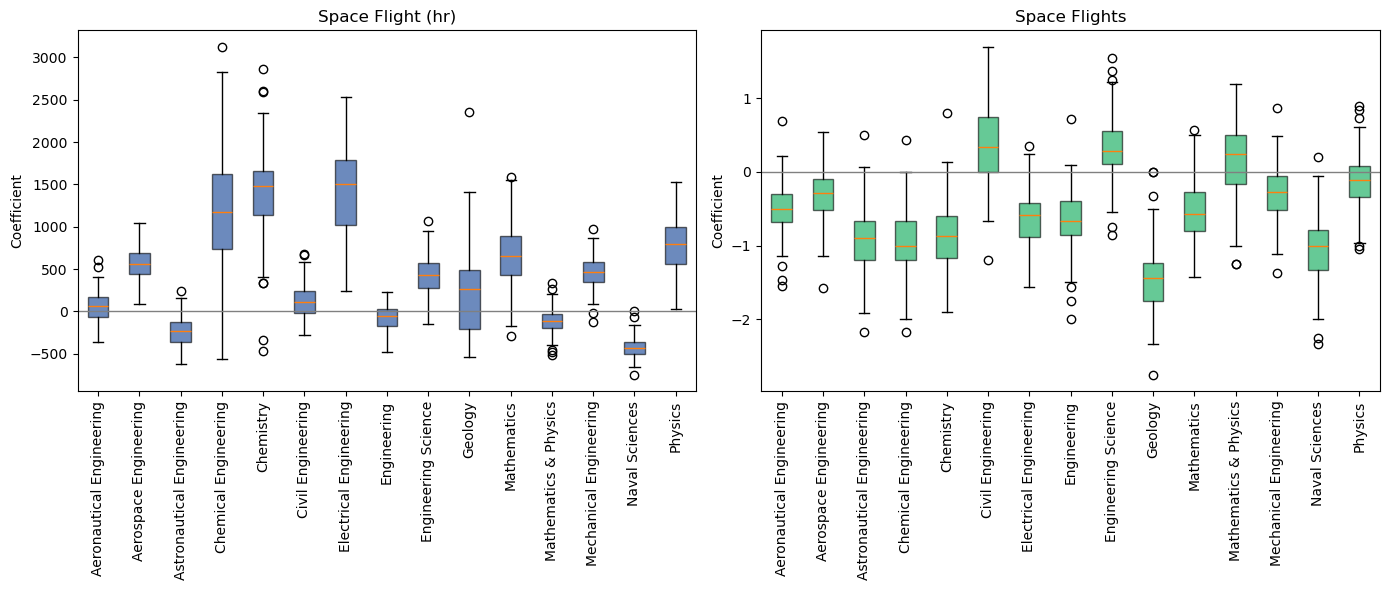

In [74]:
nasa_blue = "#0B3D91"
nasa_green = "#00A651"

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

outcome_list = ["Space Flight (hr)", "Space Flights"]
color_list = [nasa_blue, nasa_green]

# Fixed feature order (majors) on the x-axis
feature_order_maj = feature_names_maj

for idx in range(len(outcome_list)):
    outcome = outcome_list[idx]
    color = color_list[idx]
    ax = axes[idx]
    
    sub = coef_runs_maj[coef_runs_maj["Outcome"] == outcome]
    
    # Prepare data list: one array per major
    data = []
    for feat in feature_order_maj:
        coef_values = sub[sub["Feature"] == feat]["Coefficient"].values
        data.append(coef_values)
    
    box = ax.boxplot(
        data,
        vert=True,
        patch_artist=True,
        labels=feature_order_maj
    )
    
    # Color the boxes
    for b in box["boxes"]:
        b.set_facecolor(color)
        b.set_alpha(0.6)
    
    ax.axhline(0, color="grey", linewidth=1)
    ax.set_title(outcome)
    ax.set_ylabel("Coefficient")
    ax.set_xticklabels(feature_order_maj, rotation=90)

plt.tight_layout()
plt.savefig("fig_majors_coefficients_boxplots_100runs.png", dpi=300, bbox_inches="tight")
plt.show()


In [75]:
import numpy as np
import pandas as pd

# Columns we care about
cols = [
    "Space Flight (hr)",
    "Space Flights",
    "Undergraduate Major",
    "Graduate Major",
    "Military Branch",
    "Gender",
    "Year"
]

# Keep only rows where these are all present
df_lasso = df_feat[cols].dropna().copy()
print("Rows in LASSO dataset:", df_lasso.shape[0])


Rows in LASSO dataset: 144


In [76]:
# Categorical predictors we’ll one-hot encode
X_cat = df_lasso[[
    "Undergraduate Major",
    "Graduate Major",
    "Military Branch",
    "Gender"
]]

# One-hot encode, drop_first=True to avoid perfect collinearity
X_dummies = pd.get_dummies(X_cat, drop_first=True)

# Add numeric predictor(s) like Year
X = X_dummies.copy()
X["Year"] = df_lasso["Year"].values

# Targets
y_hours = df_lasso["Space Flight (hr)"]
y_flights = df_lasso["Space Flights"]

print("Design matrix shape:", X.shape)
print("Number of predictors (dummy features + Year):", X.shape[1])


Design matrix shape: (144, 128)
Number of predictors (dummy features + Year): 128


In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [78]:
from sklearn.linear_model import LassoCV

# LASSO for Space Flight (hr)
lasso_hours = LassoCV(
    cv=5,
    random_state=0
)
lasso_hours.fit(X_scaled, y_hours)

print("Best alpha for hours:", lasso_hours.alpha_)
print("R^2 (train) for hours:", lasso_hours.score(X_scaled, y_hours))

# LASSO for Space Flights
lasso_flights = LassoCV(
    cv=5,
    random_state=0
)
lasso_flights.fit(X_scaled, y_flights)

print("Best alpha for flights:", lasso_flights.alpha_)
print("R^2 (train) for flights:", lasso_flights.score(X_scaled, y_flights))


Best alpha for hours: 353.06938378197555
R^2 (train) for hours: 0.3136256898737614
Best alpha for flights: 0.16421662439358517
R^2 (train) for flights: 0.10196987996206641


In [79]:
feature_names = list(X.columns)

rows = []
for i in range(len(feature_names)):
    feat = feature_names[i]
    
    row = {
        "Feature": feat,
        "Coef_hours": lasso_hours.coef_[i],
        "Coef_flights": lasso_flights.coef_[i]
    }
    rows.append(row)

lasso_coefs = pd.DataFrame(rows)

# Add absolute values for sorting
lasso_coefs["Abs_hours"] = lasso_coefs["Coef_hours"].abs()
lasso_coefs["Abs_flights"] = lasso_coefs["Coef_flights"].abs()

# Look at the top features for each outcome
print("\nTop 15 predictors for Space Flight (hr):")
display(
    lasso_coefs.sort_values("Abs_hours", ascending=False).head(15)
)

print("\nTop 15 predictors for Space Flights:")
display(
    lasso_coefs.sort_values("Abs_flights", ascending=False).head(15)
)



Top 15 predictors for Space Flight (hr):


,Feature,Coef_hours,Coef_flights,Abs_hours,Abs_flights
55,Graduate Major_Aeronautical Engineering; Natio...,531.344975,0.0,531.344975,0.0
127,Year,271.018291,0.0,271.018291,0.0
2,Undergraduate Major_Aeronautics & Astronautics...,262.130528,0.0,262.130528,0.0
44,Undergraduate Major_Physical Science,145.945118,-0.0,145.945118,0.0
6,Undergraduate Major_Applied Science & Engineering,82.863143,0.0,82.863143,0.0
21,Undergraduate Major_Electrical Engineering,58.642266,-0.0,58.642266,0.0
50,Undergraduate Major_Systems Engineering,30.806284,0.0,30.806284,0.0
63,Graduate Major_Aeronautics & Astronautics; Phy...,7.231488,0.0,7.231488,0.0
8,Undergraduate Major_Astronautics,-0.000000,-0.0,0.000000,0.0
9,Undergraduate Major_Biological Science,-0.000000,0.0,0.000000,0.0



Top 15 predictors for Space Flights:


,Feature,Coef_hours,Coef_flights,Abs_hours,Abs_flights
98,Graduate Major_Medicine,-0.000000,-0.091713,0.000000,0.091713
16,Undergraduate Major_Civil Engineering,-0.000000,0.078816,0.000000,0.078816
40,Undergraduate Major_Naval Sciences,-0.000000,-0.058452,0.000000,0.058452
66,Graduate Major_Aerospace Engineering Sciences,0.000000,0.037047,0.000000,0.037047
97,Graduate Major_Mechanical Engineering,-0.000000,0.036062,0.000000,0.036062
79,Graduate Major_Business Management; Space Oper...,-0.000000,0.035843,0.000000,0.035843
124,Military Branch_US Navy,0.000000,-0.026043,0.000000,0.026043
104,Graduate Major_Physics,0.000000,-0.018709,0.000000,0.018709
116,Military Branch_US Air Force (Retired),-0.000000,0.006793,0.000000,0.006793
42,Undergraduate Major_Ocean Engineering,-0.000000,0.003061,0.000000,0.003061


In [80]:
# Hours: only show reasonably large effects
hours_nonzero = lasso_coefs[lasso_coefs["Abs_hours"] >= 1.0]
hours_top = hours_nonzero.sort_values("Abs_hours", ascending=False).head(15)
print("Top predictors for Space Flight (hr):")
display(hours_top)

# Flights: only show effects that are at least 0.05
flights_nonzero = lasso_coefs[lasso_coefs["Abs_flights"] >= 0.05]
flights_top = flights_nonzero.sort_values("Abs_flights", ascending=False).head(15)
print("Top predictors for Space Flights:")
display(flights_top)


Top predictors for Space Flight (hr):


,Feature,Coef_hours,Coef_flights,Abs_hours,Abs_flights
55,Graduate Major_Aeronautical Engineering; Natio...,531.344975,0.0,531.344975,0.0
127,Year,271.018291,0.0,271.018291,0.0
2,Undergraduate Major_Aeronautics & Astronautics...,262.130528,0.0,262.130528,0.0
44,Undergraduate Major_Physical Science,145.945118,-0.0,145.945118,0.0
6,Undergraduate Major_Applied Science & Engineering,82.863143,0.0,82.863143,0.0
21,Undergraduate Major_Electrical Engineering,58.642266,-0.0,58.642266,0.0
50,Undergraduate Major_Systems Engineering,30.806284,0.0,30.806284,0.0
63,Graduate Major_Aeronautics & Astronautics; Phy...,7.231488,0.0,7.231488,0.0


Top predictors for Space Flights:


,Feature,Coef_hours,Coef_flights,Abs_hours,Abs_flights
98,Graduate Major_Medicine,-0.0,-0.091713,0.0,0.091713
16,Undergraduate Major_Civil Engineering,-0.0,0.078816,0.0,0.078816
40,Undergraduate Major_Naval Sciences,-0.0,-0.058452,0.0,0.058452


In [81]:
lasso_coefs  # columns: Feature, Coef_hours, Coef_flights, Abs_hours, Abs_flights


,Feature,Coef_hours,Coef_flights,Abs_hours,Abs_flights
0,Undergraduate Major_Aeronautical Engineering,-0.000000,0.000000,0.000000,0.000000
1,Undergraduate Major_Aeronautics & Astronautics,-0.000000,-0.000000,0.000000,0.000000
2,Undergraduate Major_Aeronautics & Astronautics...,262.130528,0.000000,262.130528,0.000000
3,Undergraduate Major_Aerospace Engineering,0.000000,0.000000,0.000000,0.000000
4,Undergraduate Major_Aerospace Engineering & Me...,-0.000000,-0.000000,0.000000,0.000000
...,...,...,...,...,...
123,Military Branch_US Marine Corps Reserves,-0.000000,-0.000000,0.000000,0.000000
124,Military Branch_US Navy,0.000000,-0.026043,0.000000,0.026043
125,Military Branch_US Navy (Retired),0.000000,0.000000,0.000000,0.000000
126,Gender_Male,-0.000000,-0.000000,0.000000,0.000000


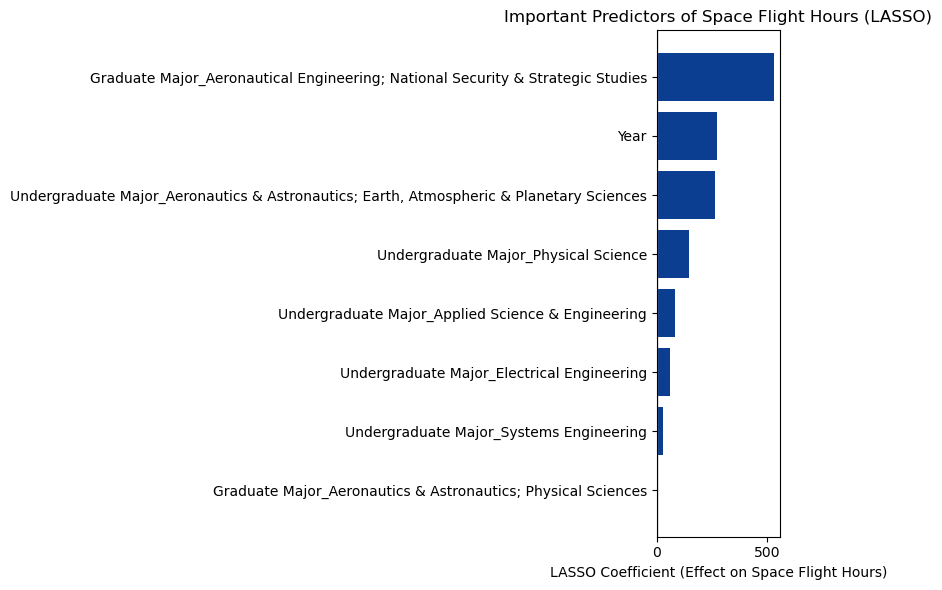

In [82]:
import matplotlib.pyplot as plt

# Filter to meaningful predictors for hours
hours_nonzero = lasso_coefs[lasso_coefs["Abs_hours"] >= 1.0].copy()

# Sort so the biggest effects appear at the top of the chart
hours_nonzero = hours_nonzero.sort_values("Abs_hours", ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(hours_nonzero["Feature"], hours_nonzero["Coef_hours"], color=nasa_blue)

ax.axvline(0, color="grey", linewidth=1)

ax.set_xlabel("LASSO Coefficient (Effect on Space Flight Hours)")
ax.set_title("Important Predictors of Space Flight Hours (LASSO)")

plt.tight_layout()
plt.savefig("lasso_hours_bar.png", dpi=300, bbox_inches="tight")
plt.show()


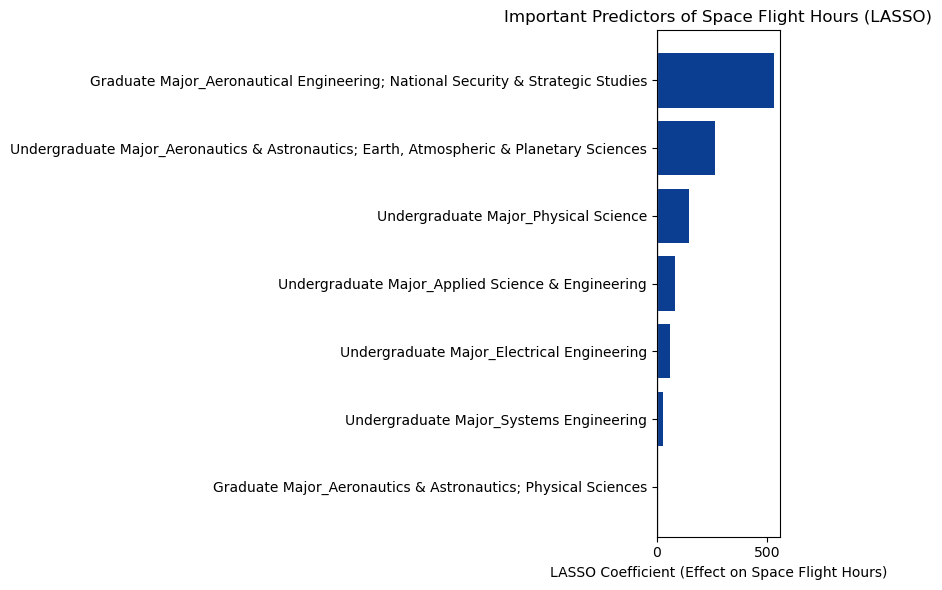

In [83]:
    import matplotlib.pyplot as plt

nasa_blue = "#0B3D91"

# Filter to meaningful predictors for hours AND drop Year
hours_nonzero = lasso_coefs[
    (lasso_coefs["Abs_hours"] >= 1.0) &
    (lasso_coefs["Feature"] != "Year")
].copy()

hours_nonzero = hours_nonzero.sort_values("Abs_hours", ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(hours_nonzero["Feature"], hours_nonzero["Coef_hours"], color=nasa_blue)
ax.axvline(0, color="grey", linewidth=1)

ax.set_xlabel("LASSO Coefficient (Effect on Space Flight Hours)")
ax.set_title("Important Predictors of Space Flight Hours (LASSO)")

plt.tight_layout()
plt.savefig("lasso_hours_bar_no_year.png", dpi=300, bbox_inches="tight")
plt.show()


Number of 'meaningful' predictors for flights (no Year): 3


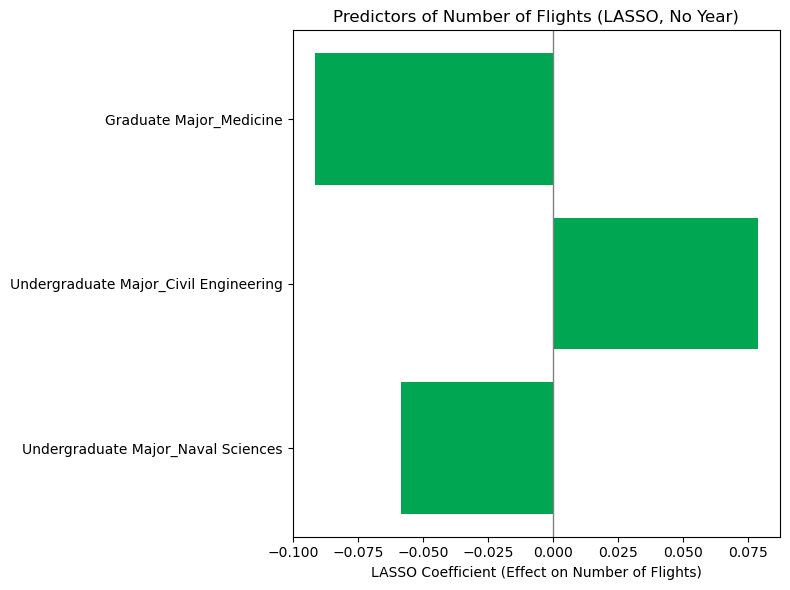

In [84]:
nasa_green = "#00A651"

flights_nonzero = lasso_coefs[
    (lasso_coefs["Abs_flights"] >= 0.05) &
    (lasso_coefs["Feature"] != "Year")
].copy()

print("Number of 'meaningful' predictors for flights (no Year):",
      flights_nonzero.shape[0])

flights_nonzero = flights_nonzero.sort_values("Abs_flights", ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))

if flights_nonzero.shape[0] > 0:
    ax.barh(flights_nonzero["Feature"], flights_nonzero["Coef_flights"], color=nasa_green)
else:
    ax.text(
        0.5, 0.5,
        "No majors/branches have a meaningful effect\non number of flights in this LASSO model.",
        ha="center", va="center", fontsize=12, transform=ax.transAxes
    )
    ax.set_yticks([])

ax.axvline(0, color="grey", linewidth=1)
ax.set_xlabel("LASSO Coefficient (Effect on Number of Flights)")
ax.set_title("Predictors of Number of Flights (LASSO, No Year)")

plt.tight_layout()
plt.savefig("lasso_flights_bar_no_year.png", dpi=300, bbox_inches="tight")
plt.show()


In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# Start from df_feat (must already exist)
# We need these columns present
cols_needed = [
    "Space Flight (hr)",
    "Space Flights",
    "Undergraduate Major",
    "Graduate Major",
    "Military Branch",
    "Gender"
]

df_lasso = df_feat[cols_needed].dropna().copy()
print("Rows before filtering:", df_lasso.shape[0])

# ---- 1A. Filter Undergraduate Majors with count >= 5 ----
ug_counts = df_lasso["Undergraduate Major"].value_counts()
ug_keep = []
for major_name in ug_counts.index:
    if ug_counts[major_name] >= 5:
        ug_keep.append(major_name)

df_lasso = df_lasso[df_lasso["Undergraduate Major"].isin(ug_keep)].copy()
print("Rows after undergrad major filter:", df_lasso.shape[0])

# ---- 1B. Filter Graduate Majors with count >= 5 ----
grad_counts = df_lasso["Graduate Major"].value_counts()
grad_keep = []
for major_name in grad_counts.index:
    if grad_counts[major_name] >= 5:
        grad_keep.append(major_name)

df_lasso = df_lasso[df_lasso["Graduate Major"].isin(grad_keep)].copy()
print("Rows after grad major filter:", df_lasso.shape[0])

# ---- 1C. Filter Military Branch with count >= 5 ----
branch_counts = df_lasso["Military Branch"].value_counts()
branch_keep = []
for b_name in branch_counts.index:
    if branch_counts[b_name] >= 5:
        branch_keep.append(b_name)

df_lasso = df_lasso[df_lasso["Military Branch"].isin(branch_keep)].copy()
print("Rows after military branch filter:", df_lasso.shape[0])


Rows before filtering: 146
Rows after undergrad major filter: 83
Rows after grad major filter: 34
Rows after military branch filter: 23


In [86]:
# Categorical predictors only (no Year)
X_cat = df_lasso[[
    "Undergraduate Major",
    "Graduate Major",
    "Military Branch",
    "Gender"
]]

# One-hot encode specific majors/branches/gender
X_dummies = pd.get_dummies(X_cat, drop_first=True)

X = X_dummies.copy()   # no Year added
feature_names = list(X.columns)

# Targets
y_hours = df_lasso["Space Flight (hr)"]
y_flights = df_lasso["Space Flights"]

print("Design matrix shape:", X.shape)
print("Number of dummy features:", X.shape[1])


Design matrix shape: (23, 12)
Number of dummy features: 12


In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# Scale predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- LASSO for Space Flight (hr) ----
lasso_hours = LassoCV(cv=5, random_state=0)
lasso_hours.fit(X_scaled, y_hours)

print("Best alpha for HOURS:", lasso_hours.alpha_)
print("R^2 (train) for HOURS:", lasso_hours.score(X_scaled, y_hours))

# ---- LASSO for Space Flights ----
lasso_flights = LassoCV(cv=5, random_state=0)
lasso_flights.fit(X_scaled, y_flights)

print("Best alpha for FLIGHTS:", lasso_flights.alpha_)
print("R^2 (train) for FLIGHTS:", lasso_flights.score(X_scaled, y_flights))


Best alpha for HOURS: 931.0039591366766
R^2 (train) for HOURS: 0.0
Best alpha for FLIGHTS: 0.6732853059244749
R^2 (train) for FLIGHTS: 0.0


In [88]:
rows = []

for i in range(len(feature_names)):
    feat = feature_names[i]
    coef_h = lasso_hours.coef_[i]
    coef_f = lasso_flights.coef_[i]

    row = {
        "Feature": feat,
        "Coef_hours": coef_h,
        "Coef_flights": coef_f,
        "Abs_hours": abs(coef_h),
        "Abs_flights": abs(coef_f)
    }
    rows.append(row)

lasso_coefs_filtered = pd.DataFrame(rows)
lasso_coefs_filtered.head()


,Feature,Coef_hours,Coef_flights,Abs_hours,Abs_flights
0,Undergraduate Major_Aerospace Engineering,-0.0,-0.0,0.0,0.0
1,Undergraduate Major_Astronautical Engineering,-0.0,-0.0,0.0,0.0
2,Undergraduate Major_Electrical Engineering,0.0,-0.0,0.0,0.0
3,Undergraduate Major_Engineering,-0.0,0.0,0.0,0.0
4,Undergraduate Major_Engineering Science,-0.0,0.0,0.0,0.0


Number of 'meaningful' predictors for flights (n ≥ 5, no Year): 0


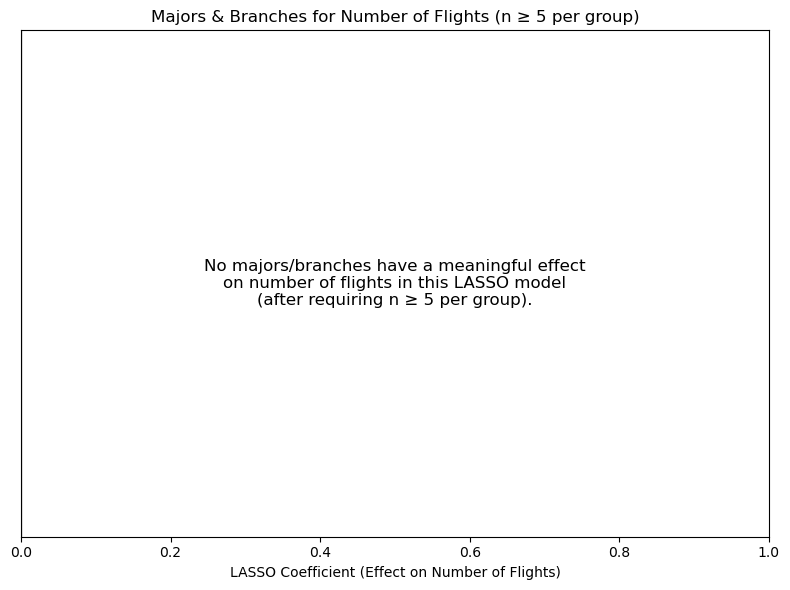

In [89]:
nasa_green = "#00A651"

flights_nonzero = lasso_coefs_filtered[
    lasso_coefs_filtered["Abs_flights"] >= 0.05
].copy()

print("Number of 'meaningful' predictors for flights (n ≥ 5, no Year):",
      flights_nonzero.shape[0])

flights_nonzero = flights_nonzero.sort_values("Abs_flights", ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))

if flights_nonzero.shape[0] > 0:
    ax.barh(flights_nonzero["Feature"], flights_nonzero["Coef_flights"], color=nasa_green)
else:
    ax.text(
        0.5, 0.5,
        "No majors/branches have a meaningful effect\non number of flights in this LASSO model\n(after requiring n ≥ 5 per group).",
        ha="center", va="center", fontsize=12, transform=ax.transAxes
    )
    ax.set_yticks([])

ax.axvline(0, color="grey", linewidth=1)
ax.set_xlabel("LASSO Coefficient (Effect on Number of Flights)")
ax.set_title("Majors & Branches for Number of Flights (n ≥ 5 per group)")

plt.tight_layout()
plt.savefig("lasso_flights_bar_major_branch_n5.png", dpi=300, bbox_inches="tight")
plt.show()
